In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



from pathlib import Path

# data_dir = 'coco_dataset/val2017_subset/'
data_dir = 'coco_dataset/test2017_small_test/'

image_size = (256, 256)
batch_size = 4

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)

    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0

    return (grayscale, color_mask), image


# from skimage.color import rgb2lab, lab2lch
import tensorflow_io
from tensorflow_io.python.experimental.color_ops import rgb_to_lab
def preprocess_lab(image):

    image = tf.cast(image/255, tf.float32)
    lab = rgb_to_lab(image)
    l = lab[...,0]/100.0
    a = ( lab[...,1] + 128.0) /256.0
    b = ( lab[...,2] + 128.0) /256.0
    # l = lab[...,0] / 100.0
    # a = ( lab[...,1] + 128.0) /255.0
    # b = (lab[...,2] + 128.0) /255.0
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)
    ab = tf.concat([a,b], axis=-1)
    print(l.shape, ab.shape)
    return l, ab


# colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 
colorization_dataset = dataset.map(preprocess_lab, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)



# Function to convert Lab to RGB for visualization
def convert_lab_to_rgb(l_channel, ab_channels):
    """
    Converts L and ab channels into RGB format using skimage's lab2rgb.
    """
    l_channel = (l_channel) * 100.0  # Scale back to Lab range
    ab_channels = (ab_channels * 256.0) - 128.0  # Scale back to Lab range
    # l_channel = (l_channel ) * 255.0 - 128.0  # Scale back to Lab range
    # ab_channels = ab_channels * 255.0 - 128.0  # Scale back to Lab range
    # print('lachannel ' , l_channel)
    # print('ab_channels' , ab_channels)
    # lab_image = np.concatenate([l_channel, ab_channels], axis=-1)
    # print(lab_image)
    # rgb_image = lab2rgb(lab_image)  # Convert to RGB
    lab = tf.concat([l_channel,ab_channels], axis=-1)
    rgb = tensorflow_io.python.experimental.color_ops.lab_to_rgb(lab)
    # plt.imshow(rgb)

    return rgb

# Function to predict and visualize colorized images
def predict_and_visualize(model, dataset, num_images=5):
    """
    Predicts and visualizes images from the dataset.
    Args:
        model: Trained colorization model
        dataset: Dataset with grayscale (L channel) inputs
        num_images: Number of images to visualize
    """
    losses = []
    # Take a batch of images
    for batch, ground_truth in dataset.take(1):
        # Only take 1 batch for visualization
        # print(batch)
        l_inputs = batch
        l_inputs = l_inputs[:num_images]  # Limit the number of images
        ground_truth = ground_truth[:num_images]

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)


        # Prepare for visualization
        for i in range(num_images):
            l_channel = l_inputs[i]
            ab_channels_pred = predicted_ab[i]
            ab_channels_gt = ground_truth[i]
            # print(ground_truth[i].shape, predicted_ab[i].shape, ab_channels_gt.shape, ab_channels_pred.shape)

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)

            # Plot images
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(l_channel, cmap="gray")
            plt.title("Grayscale (L Channel)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_rgb)
            plt.title("Predicted Colorization")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(gt_rgb)
            plt.title("Ground Truth Colorization")
            plt.axis("off")

            plt.show()
            # losses.append(tf.reduce_mean(tf.square( ab_channels_gt, ab_channels_pred)))
            losses.append(tf.reduce_mean(tf.square( pred_rgb, gt_rgb)))
            mse = tf.keras.losses.MeanSquaredError()
            print( mse( pred_rgb, gt_rgb))
            print(mse( ab_channels_gt, ab_channels_pred))
            print(tf.reduce_mean(tf.square( ab_channels_gt, ab_channels_pred)) )

        return losses



Found 100 files.


I0000 00:00:1734453753.980754  260284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734453754.009962  260284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734453754.010111  260284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734453754.010934  260284 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

(None, 256, 256, 1) (None, 256, 256, 2)


In [3]:
from keras.models import load_model
saved_model = load_model('lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras')


ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


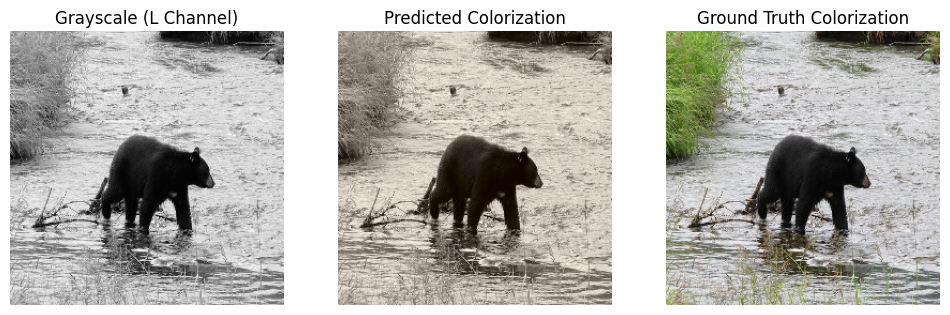

tf.Tensor(0.0028868387, shape=(), dtype=float32)
tf.Tensor(0.0013704435, shape=(), dtype=float32)
tf.Tensor(0.25652453, shape=(), dtype=float32)


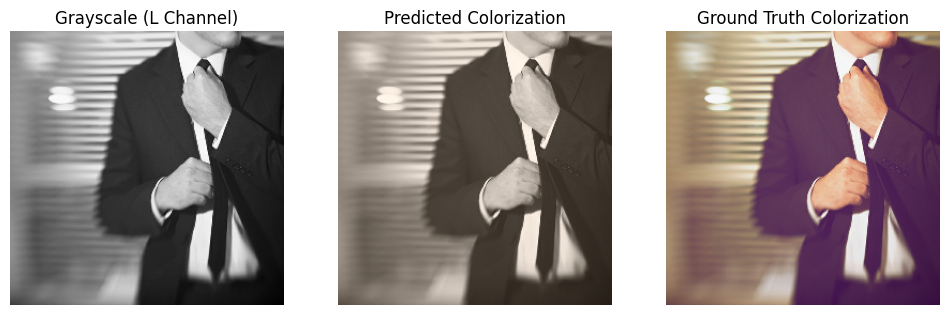

tf.Tensor(0.005728896, shape=(), dtype=float32)
tf.Tensor(0.004279892, shape=(), dtype=float32)
tf.Tensor(0.28565967, shape=(), dtype=float32)


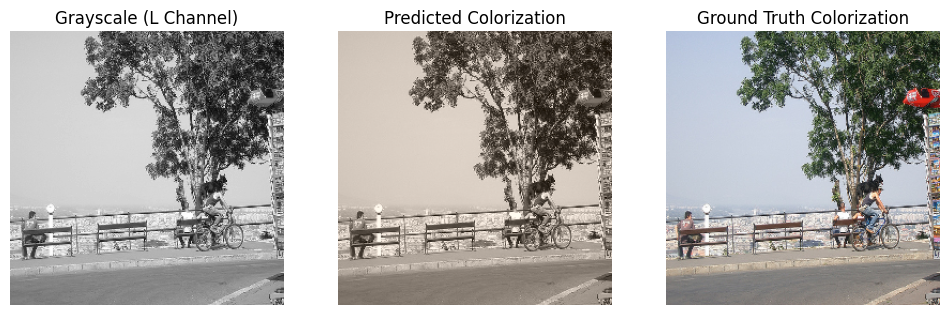

tf.Tensor(0.0033310237, shape=(), dtype=float32)
tf.Tensor(0.0012669403, shape=(), dtype=float32)
tf.Tensor(0.2500633, shape=(), dtype=float32)


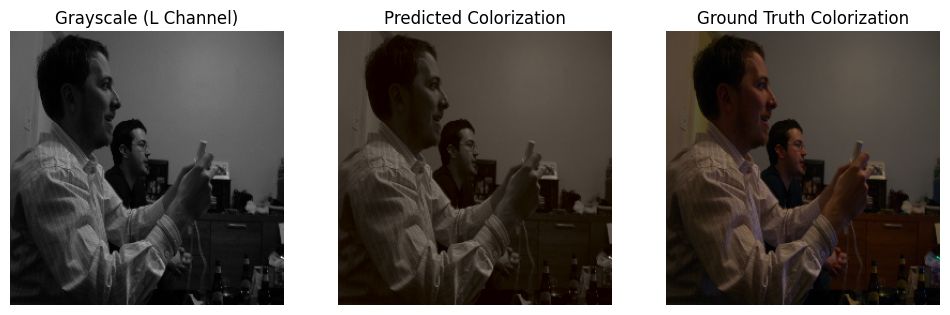

tf.Tensor(0.000509322, shape=(), dtype=float32)
tf.Tensor(0.00028833747, shape=(), dtype=float32)
tf.Tensor(0.26993167, shape=(), dtype=float32)


2024-12-12 17:27:08.082756: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [7]:
predict_and_visualize(saved_model, val_dataset)

In [4]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from skimage import io, color
import os
import matplotlib.pyplot as plt
import random
from skimage import transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.models import load_model
from tensorflow.keras.optimizers import Adam


In [5]:
def psnr(y_true, y_pred):
    max_pixel = 1.0  
    # print(y_true.shape, y_pred.shape)
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    max_pixel = 1.0  
    return tf.image.ssim(y_true, y_pred, max_val=max_pixel)
import json
def save_loss(history, path):
    with open(path + ".json", 'w') as f:
        json.dump(history.history, f)

In [36]:
from pathlib import Path

data_dir = 'coco_dataset/test2017_small_test/'
# data_dir = 'coco_dataset/test2017_benchmark_10000/'

image_size = (256, 256)
batch_size = 4

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(grayscale.shape, image.shape)
    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0
    return (grayscale, color_mask), image


# from skimage.color import rgb2lab, lab2lch
import tensorflow_io
from tensorflow_io.python.experimental.color_ops import rgb_to_lab
def preprocess_lab(image):

    image = tf.cast(image/255, tf.float32)
    lab = rgb_to_lab(image)
    l = lab[...,0]/100.0
    a = ( lab[...,1] + 128.0) /256.0
    b = ( lab[...,2] + 128.0) /256.0
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)
    ab = tf.concat([a,b], axis=-1)
    print(l.shape, ab.shape)
    return l, ab, l

colorization_dataset = dataset.map(preprocess_lab, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)



Found 83 files.
(None, 256, 256, 1) (None, 256, 256, 2)


In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to convert Lab to RGB for visualization
def convert_lab_to_rgb(l_channel, ab_channels):
    """
    Converts L and ab channels into RGB format using skimage's lab2rgb.
    """
    l_channel = (l_channel ) * 100.0  # Scale back to Lab range
    ab_channels = (ab_channels ) * 256.0 - 128 # Scale back to Lab range
    lab = tf.concat([l_channel,ab_channels], axis=-1)
    rgb = tensorflow_io.python.experimental.color_ops.lab_to_rgb(lab)

    return rgb
# Updated function to include SSIM and PSNR metrics
def predict_and_visualize(model, dataset, num_images=5):
    """
    Predicts and visualizes images from the dataset, and computes SSIM and PSNR metrics.
    Args:
        model: Trained colorization model
        dataset: Dataset with grayscale (L channel) inputs
        num_images: Number of images to visualize
    """
    losses = []
    ssim_values = []
    psnr_values = []

    # Take a batch of images
    for batch, ground_truth, l in dataset.take(1):
        # Only take 1 batch for visualization
        l_inputs = batch
        l_inputs = l_inputs[:num_images]  # Limit the number of images
        ground_truth = ground_truth[:num_images]

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)

        # Prepare for visualization and metric calculation
        for i in range(num_images):
            l_channel = l_inputs[i]
            ab_channels_pred = np.array(predicted_ab[i])
            ab_channels_gt = ground_truth[i]

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)
            # print(pred_rgb)
            # Calculate SSIM and PSNR
            ssim_value = tf.image.ssim(pred_rgb, gt_rgb, max_val=1.0)
            psnr_value = tf.image.psnr(pred_rgb, gt_rgb, max_val=1.0)

            ssim_values.append(ssim_value.numpy())
            psnr_values.append(psnr_value.numpy())

            # Plot images
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 7, 1)
            plt.imshow(l_channel, cmap="gray")
            plt.title("Grayscale (L Channel)")
            plt.axis("off")

            plt.subplot(1, 7, 2)
            plt.imshow(ab_channels_pred[..., 1], cmap="gray")
            plt.title("Predicted b")
            plt.axis("off")

            plt.subplot(1, 7, 3)
            plt.imshow(ab_channels_gt[..., 1], cmap="gray")
            plt.title("Ground Truth b")
            plt.axis("off")

            plt.subplot(1, 7, 4)
            plt.imshow(ab_channels_pred[..., 0], cmap="gray")
            plt.title("Predicted a")
            plt.axis("off")

            plt.subplot(1, 7, 5)
            plt.imshow(ab_channels_gt[..., 0], cmap="gray")
            plt.title("Ground Truth a")
            plt.axis("off")

            plt.subplot(1, 7, 6)
            plt.imshow(pred_rgb)
            plt.title("Predicted RGB")
            plt.axis("off")

            plt.subplot(1, 7, 7)
            plt.imshow(gt_rgb)
            plt.title("Ground Truth RGB")
            plt.axis("off")

            plt.suptitle(f"SSIM: {ssim_value.numpy():.4f}, PSNR: {psnr_value.numpy():.2f} dB", fontsize=16)
            plt.show()

            # Calculate and store MSE losses for visualization
            mse = tf.keras.losses.MeanSquaredError()
            losses.append(mse(ab_channels_gt, ab_channels_pred).numpy())

    # Print average SSIM and PSNR
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")
    print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")

    return losses, ssim_values, psnr_values


In [38]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Flatten, Dense, RepeatVector, Reshape, Lambda
from tensorflow.keras.applications import VGG16

input_shape = (256,256,1)


def create_lab_colorization_model_with_vgg_features():
    input_l = Input(shape=(input_shape[0], input_shape[1], 1), name="Input_L")
    input_l_rgb = Lambda(lambda x: tf.image.grayscale_to_rgb(x), name="Pseudo_RGB")(input_l)

    # Extract features from VGG16
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    vgg_extractor = Model(vgg_model.input, vgg_model.layers[-6].output)  
    vgg_features = vgg_extractor(input_l_rgb)  

    # Process global features with additional layers
    global_features = Conv2D(512, (3, 3), padding='same', strides=(2, 2), activation='relu')(vgg_features)
    global_features = BatchNormalization()(global_features)
    global_features = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(global_features)
    global_features = BatchNormalization()(global_features)
    global_features = UpSampling2D((2, 2))(global_features)

    # Encoder (downsampling) with skip connections
    x1 = Conv2D(64, (3, 3), activation="relu", padding="same", strides=1)(input_l)
    x1 = BatchNormalization()(x1)
    x2 = Conv2D(128, (3, 3), activation="relu", padding="same", strides=2)(x1)  
    x2 = BatchNormalization()(x2)
    x3 = Conv2D(256, (3, 3), activation="relu", padding="same", strides=2)(x2)  
    x3 = BatchNormalization()(x3)
    x4 = Conv2D(512, (3, 3), activation="relu", padding="same", strides=2)(x3)  
    x4 = BatchNormalization()(x4)

    # Merge global features into the decoder
    x4 = Concatenate()([x4, global_features])
    x4 = BatchNormalization()(x4)

    # Decoder (upsampling) with skip connections
    x5 = UpSampling2D((2, 2))(x4)  # Upsampling
    x5 = Concatenate()([x5, x3])  # Skip connection
    x5 = Conv2D(256, (3, 3), activation="relu", padding="same")(x5)
    x5 = BatchNormalization()(x5)

    x6 = UpSampling2D((2, 2))(x5)  # Upsampling
    x6 = Concatenate()([x6, x2])  # Skip connection
    x6 = Conv2D(128, (3, 3), activation="relu", padding="same")(x6)
    x6 = BatchNormalization()(x6)

    x7 = UpSampling2D((2, 2))(x6)  # Upsampling
    x7 = Concatenate()([x7, x1])  # Skip connection
    x7 = Conv2D(64, (3, 3), activation="relu", padding="same")(x7)
    x7 = BatchNormalization()(x7)

    # Final output layer for ab channels
    ab_output = Conv2D(2, (1, 1), activation="sigmoid", name="Output_ab")(x7)

    # Combine inputs and outputs into the final model
    model = Model(inputs=input_l, outputs=[ab_output], name="Lab_Colorization_Model_With_VGG_Features")

    return model





In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Lambda
from keras.models import Sequential, Model


# Redefine the custom Lambda layer with explicit output shape
def pseudo_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Include the custom Lambda layer in custom_objects with the correct shape
custom_objects = {
    "psnr": psnr,
    "ssim": ssim,
    "Pseudo_RGB": Lambda(pseudo_rgb, output_shape=(256, 256, 3))
}

# # Load the model with custom objects
# saved_model = load_model(
#     "lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras",
#     safe_mode=False,
#     custom_objects=custom_objects
# )

model = create_lab_colorization_model_with_vgg_features()
model.load_weights("lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras")  # Replace with your weights file



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


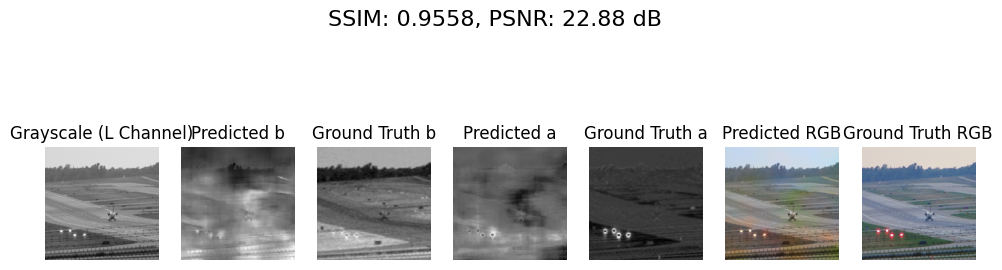

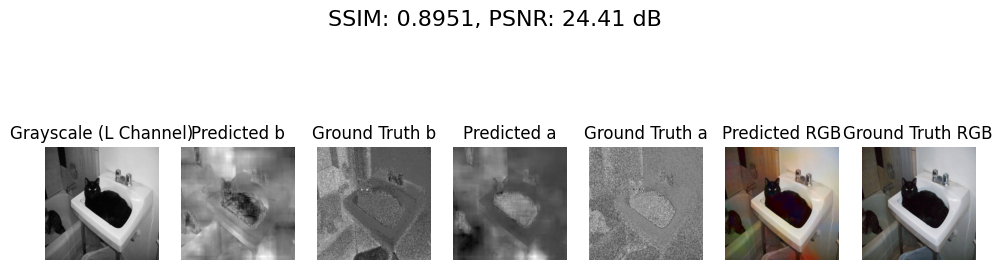

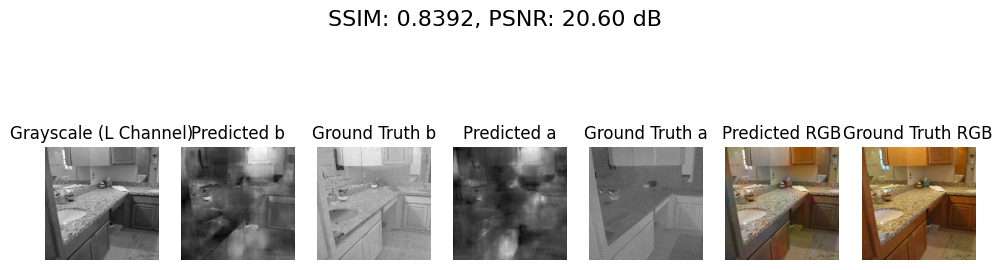

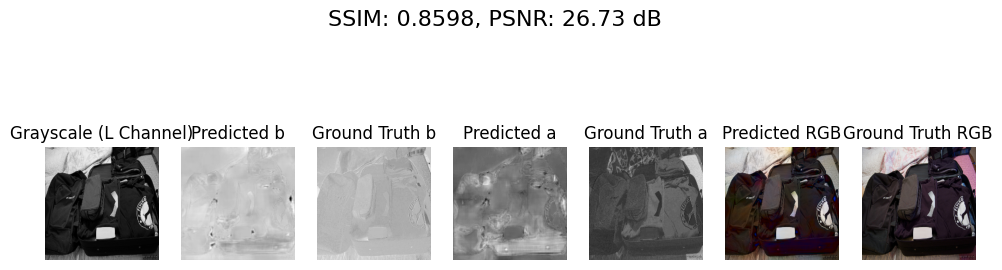

2024-12-17 20:34:21.739501: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [40]:
predict_and_visualize(model, train_dataset)

In [23]:
import re
import json

# L'output de la cellule Jupyter
cell_output = """
Epoch 1/75
W0000 00:00:1734387739.080504  210367 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734387739.081480  210367 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0203 - mae: 0.0995 - mse: 0.0203 - psnr: 18.2230 - ssim: 0.5214
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - loss: 0.0203 - mae: 0.0995 - mse: 0.0203 - psnr: 18.2237 - ssim: 0.5214 - val_loss: 0.0130 - val_mae: 0.0799 - val_mse: 0.0130 - val_psnr: 19.7369 - val_ssim: 0.6374
Epoch 2/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0121 - mae: 0.0754 - mse: 0.0121 - psnr: 20.1026 - ssim: 0.6516
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0121 - mae: 0.0754 - mse: 0.0121 - psnr: 20.1026 - ssim: 0.6516 - val_loss: 0.0113 - val_mae: 0.0733 - val_mse: 0.0113 - val_psnr: 20.4111 - val_ssim: 0.6842
Epoch 3/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0116 - mae: 0.0736 - mse: 0.0116 - psnr: 20.3336 - ssim: 0.6819
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0116 - mae: 0.0736 - mse: 0.0116 - psnr: 20.3336 - ssim: 0.6819 - val_loss: 0.0110 - val_mae: 0.0707 - val_mse: 0.0110 - val_psnr: 20.6372 - val_ssim: 0.7008
Epoch 4/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0110 - mae: 0.0716 - mse: 0.0110 - psnr: 20.5349 - ssim: 0.6967
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0110 - mae: 0.0716 - mse: 0.0110 - psnr: 20.5349 - ssim: 0.6967 - val_loss: 0.0108 - val_mae: 0.0711 - val_mse: 0.0108 - val_psnr: 20.7079 - val_ssim: 0.7098
Epoch 5/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0108 - mae: 0.0705 - mse: 0.0108 - psnr: 20.6819 - ssim: 0.7082
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0108 - mae: 0.0705 - mse: 0.0108 - psnr: 20.6819 - ssim: 0.7082 - val_loss: 0.0113 - val_mae: 0.0727 - val_mse: 0.0113 - val_psnr: 20.3503 - val_ssim: 0.6895
Epoch 6/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0106 - mae: 0.0699 - mse: 0.0106 - psnr: 20.7399 - ssim: 0.7126
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0106 - mae: 0.0699 - mse: 0.0106 - psnr: 20.7399 - ssim: 0.7126 - val_loss: 0.0108 - val_mae: 0.0701 - val_mse: 0.0108 - val_psnr: 20.6678 - val_ssim: 0.7180
Epoch 7/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0103 - mae: 0.0687 - mse: 0.0103 - psnr: 20.8889 - ssim: 0.7208
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 93s 44ms/step - loss: 0.0103 - mae: 0.0687 - mse: 0.0103 - psnr: 20.8889 - ssim: 0.7208 - val_loss: 0.0102 - val_mae: 0.0672 - val_mse: 0.0102 - val_psnr: 21.0154 - val_ssim: 0.7344
Epoch 8/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0102 - mae: 0.0683 - mse: 0.0102 - psnr: 20.9397 - ssim: 0.7265
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0102 - mae: 0.0683 - mse: 0.0102 - psnr: 20.9397 - ssim: 0.7265 - val_loss: 0.0099 - val_mae: 0.0664 - val_mse: 0.0099 - val_psnr: 21.1435 - val_ssim: 0.7368
Epoch 9/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0100 - mae: 0.0675 - mse: 0.0100 - psnr: 21.0359 - ssim: 0.7335
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0100 - mae: 0.0675 - mse: 0.0100 - psnr: 21.0359 - ssim: 0.7335 - val_loss: 0.0105 - val_mae: 0.0686 - val_mse: 0.0105 - val_psnr: 20.8610 - val_ssim: 0.7066
Epoch 10/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0100 - mae: 0.0675 - mse: 0.0100 - psnr: 21.0322 - ssim: 0.7350
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0100 - mae: 0.0675 - mse: 0.0100 - psnr: 21.0322 - ssim: 0.7350 - val_loss: 0.0099 - val_mae: 0.0659 - val_mse: 0.0099 - val_psnr: 21.2212 - val_ssim: 0.7452
Epoch 11/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0098 - mae: 0.0665 - mse: 0.0098 - psnr: 21.1440 - ssim: 0.7427
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0098 - mae: 0.0665 - mse: 0.0098 - psnr: 21.1440 - ssim: 0.7427 - val_loss: 0.0098 - val_mae: 0.0666 - val_mse: 0.0098 - val_psnr: 21.0909 - val_ssim: 0.7422
Epoch 12/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0097 - mae: 0.0665 - mse: 0.0097 - psnr: 21.1432 - ssim: 0.7441
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0097 - mae: 0.0665 - mse: 0.0097 - psnr: 21.1432 - ssim: 0.7441 - val_loss: 0.0100 - val_mae: 0.0687 - val_mse: 0.0100 - val_psnr: 21.0071 - val_ssim: 0.7442
Epoch 13/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0097 - mae: 0.0664 - mse: 0.0097 - psnr: 21.1904 - ssim: 0.7494
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0097 - mae: 0.0664 - mse: 0.0097 - psnr: 21.1904 - ssim: 0.7494 - val_loss: 0.0095 - val_mae: 0.0656 - val_mse: 0.0095 - val_psnr: 21.2859 - val_ssim: 0.7482
Epoch 14/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0094 - mae: 0.0654 - mse: 0.0094 - psnr: 21.2854 - ssim: 0.7531
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0094 - mae: 0.0654 - mse: 0.0094 - psnr: 21.2854 - ssim: 0.7531 - val_loss: 0.0094 - val_mae: 0.0642 - val_mse: 0.0094 - val_psnr: 21.3911 - val_ssim: 0.7593
Epoch 15/75
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0093 - mae: 0.0649 - mse: 0.0093 - psnr: 21.3598 - ssim: 0.7573
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0093 - mae: 0.0649 - mse: 0.0093 - psnr: 21.3598 - ssim: 0.7573 - val_loss: 0.0094 - val_mae: 0.0648 - val_mse: 0.0094 - val_psnr: 21.3151 - val_ssim: 0.7606
Epoch 16/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0092 - mae: 0.0647 - mse: 0.0092 - psnr: 21.3728 - ssim: 0.7588
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0092 - mae: 0.0647 - mse: 0.0092 - psnr: 21.3728 - ssim: 0.7588 - val_loss: 0.0096 - val_mae: 0.0661 - val_mse: 0.0096 - val_psnr: 21.2726 - val_ssim: 0.7603
Epoch 17/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0093 - mae: 0.0648 - mse: 0.0093 - psnr: 21.3743 - ssim: 0.7610
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0093 - mae: 0.0648 - mse: 0.0093 - psnr: 21.3743 - ssim: 0.7610 - val_loss: 0.0101 - val_mae: 0.0672 - val_mse: 0.0101 - val_psnr: 20.9484 - val_ssim: 0.7411
Epoch 18/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0092 - mae: 0.0646 - mse: 0.0092 - psnr: 21.4011 - ssim: 0.7611
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0092 - mae: 0.0646 - mse: 0.0092 - psnr: 21.4011 - ssim: 0.7611 - val_loss: 0.0095 - val_mae: 0.0659 - val_mse: 0.0095 - val_psnr: 21.2021 - val_ssim: 0.7520
Epoch 19/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0092 - mae: 0.0646 - mse: 0.0092 - psnr: 21.3943 - ssim: 0.7647
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 93s 44ms/step - loss: 0.0092 - mae: 0.0646 - mse: 0.0092 - psnr: 21.3943 - ssim: 0.7647 - val_loss: 0.0094 - val_mae: 0.0645 - val_mse: 0.0094 - val_psnr: 21.4372 - val_ssim: 0.7694
Epoch 20/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0091 - mae: 0.0642 - mse: 0.0091 - psnr: 21.4554 - ssim: 0.7664
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0091 - mae: 0.0642 - mse: 0.0091 - psnr: 21.4554 - ssim: 0.7664 - val_loss: 0.0094 - val_mae: 0.0650 - val_mse: 0.0094 - val_psnr: 21.3603 - val_ssim: 0.7493
Epoch 21/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0090 - mae: 0.0639 - mse: 0.0090 - psnr: 21.4587 - ssim: 0.7658
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0090 - mae: 0.0639 - mse: 0.0090 - psnr: 21.4587 - ssim: 0.7659 - val_loss: 0.0095 - val_mae: 0.0651 - val_mse: 0.0095 - val_psnr: 21.2874 - val_ssim: 0.7685
Epoch 22/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0089 - mae: 0.0633 - mse: 0.0089 - psnr: 21.5546 - ssim: 0.7694
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0089 - mae: 0.0633 - mse: 0.0089 - psnr: 21.5546 - ssim: 0.7694 - val_loss: 0.0093 - val_mae: 0.0639 - val_mse: 0.0093 - val_psnr: 21.5411 - val_ssim: 0.7693
Epoch 23/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0089 - mae: 0.0634 - mse: 0.0089 - psnr: 21.5429 - ssim: 0.7714
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0089 - mae: 0.0634 - mse: 0.0089 - psnr: 21.5429 - ssim: 0.7714 - val_loss: 0.0092 - val_mae: 0.0643 - val_mse: 0.0092 - val_psnr: 21.4598 - val_ssim: 0.7824
Epoch 24/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6456 - ssim: 0.7739
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6456 - ssim: 0.7739 - val_loss: 0.0095 - val_mae: 0.0653 - val_mse: 0.0095 - val_psnr: 21.2533 - val_ssim: 0.7562
Epoch 25/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6201 - ssim: 0.7718
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6201 - ssim: 0.7718 - val_loss: 0.0098 - val_mae: 0.0669 - val_mse: 0.0098 - val_psnr: 21.1555 - val_ssim: 0.7649
Epoch 26/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6266 - ssim: 0.7730
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0087 - mae: 0.0627 - mse: 0.0087 - psnr: 21.6266 - ssim: 0.7730 - val_loss: 0.0092 - val_mae: 0.0641 - val_mse: 0.0092 - val_psnr: 21.4127 - val_ssim: 0.7782
Epoch 27/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0085 - mae: 0.0622 - mse: 0.0085 - psnr: 21.6738 - ssim: 0.7743
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0085 - mae: 0.0622 - mse: 0.0085 - psnr: 21.6738 - ssim: 0.7743 - val_loss: 0.0095 - val_mae: 0.0652 - val_mse: 0.0095 - val_psnr: 21.1822 - val_ssim: 0.7714
Epoch 28/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0083 - mae: 0.0614 - mse: 0.0083 - psnr: 21.7414 - ssim: 0.7769
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0083 - mae: 0.0614 - mse: 0.0083 - psnr: 21.7414 - ssim: 0.7769 - val_loss: 0.0094 - val_mae: 0.0654 - val_mse: 0.0094 - val_psnr: 21.1841 - val_ssim: 0.7615
Epoch 29/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0083 - mae: 0.0612 - mse: 0.0083 - psnr: 21.7903 - ssim: 0.7776
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0083 - mae: 0.0612 - mse: 0.0083 - psnr: 21.7903 - ssim: 0.7776 - val_loss: 0.0092 - val_mae: 0.0642 - val_mse: 0.0092 - val_psnr: 21.3586 - val_ssim: 0.7726
Epoch 30/75
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0082 - mae: 0.0609 - mse: 0.0082 - psnr: 21.8144 - ssim: 0.7767
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0082 - mae: 0.0609 - mse: 0.0082 - psnr: 21.8144 - ssim: 0.7767 - val_loss: 0.0101 - val_mae: 0.0685 - val_mse: 0.0101 - val_psnr: 20.8452 - val_ssim: 0.7263
Epoch 31/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0081 - mae: 0.0609 - mse: 0.0081 - psnr: 21.8052 - ssim: 0.7735
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0081 - mae: 0.0609 - mse: 0.0081 - psnr: 21.8052 - ssim: 0.7735 - val_loss: 0.0093 - val_mae: 0.0646 - val_mse: 0.0093 - val_psnr: 21.3409 - val_ssim: 0.7589
Epoch 32/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0080 - mae: 0.0605 - mse: 0.0080 - psnr: 21.8711 - ssim: 0.7761
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 93s 44ms/step - loss: 0.0080 - mae: 0.0605 - mse: 0.0080 - psnr: 21.8711 - ssim: 0.7761 - val_loss: 0.0089 - val_mae: 0.0618 - val_mse: 0.0089 - val_psnr: 21.6984 - val_ssim: 0.7812
Epoch 33/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0079 - mae: 0.0600 - mse: 0.0079 - psnr: 21.9048 - ssim: 0.7741
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0079 - mae: 0.0600 - mse: 0.0079 - psnr: 21.9048 - ssim: 0.7741 - val_loss: 0.0093 - val_mae: 0.0640 - val_mse: 0.0093 - val_psnr: 21.4876 - val_ssim: 0.7724
Epoch 34/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0077 - mae: 0.0593 - mse: 0.0077 - psnr: 21.9946 - ssim: 0.7763
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0077 - mae: 0.0593 - mse: 0.0077 - psnr: 21.9946 - ssim: 0.7763 - val_loss: 0.0092 - val_mae: 0.0641 - val_mse: 0.0092 - val_psnr: 21.3200 - val_ssim: 0.7719
Epoch 35/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0076 - mae: 0.0590 - mse: 0.0076 - psnr: 22.0183 - ssim: 0.7754
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0076 - mae: 0.0590 - mse: 0.0076 - psnr: 22.0183 - ssim: 0.7754 - val_loss: 0.0095 - val_mae: 0.0649 - val_mse: 0.0095 - val_psnr: 21.2110 - val_ssim: 0.7771
Epoch 36/75
1995/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0075 - mae: 0.0587 - mse: 0.0075 - psnr: 22.0751 - ssim: 0.7751
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0075 - mae: 0.0587 - mse: 0.0075 - psnr: 22.0751 - ssim: 0.7751 - val_loss: 0.0090 - val_mae: 0.0630 - val_mse: 0.0090 - val_psnr: 21.4717 - val_ssim: 0.7745
Epoch 37/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0073 - mae: 0.0576 - mse: 0.0073 - psnr: 22.2081 - ssim: 0.7772
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0073 - mae: 0.0576 - mse: 0.0073 - psnr: 22.2081 - ssim: 0.7772 - val_loss: 0.0095 - val_mae: 0.0649 - val_mse: 0.0095 - val_psnr: 21.1854 - val_ssim: 0.7714
Epoch 38/75
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0073 - mae: 0.0576 - mse: 0.0073 - psnr: 22.2079 - ssim: 0.7761
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0073 - mae: 0.0576 - mse: 0.0073 - psnr: 22.2079 - ssim: 0.7761 - val_loss: 0.0094 - val_mae: 0.0648 - val_mse: 0.0094 - val_psnr: 21.2374 - val_ssim: 0.7693
Epoch 39/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0070 - mae: 0.0568 - mse: 0.0070 - psnr: 22.3029 - ssim: 0.7772
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0070 - mae: 0.0568 - mse: 0.0070 - psnr: 22.3028 - ssim: 0.7772 - val_loss: 0.0093 - val_mae: 0.0642 - val_mse: 0.0093 - val_psnr: 21.2660 - val_ssim: 0.7751
Epoch 40/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0070 - mae: 0.0565 - mse: 0.0070 - psnr: 22.3570 - ssim: 0.7764
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0070 - mae: 0.0565 - mse: 0.0070 - psnr: 22.3570 - ssim: 0.7764 - val_loss: 0.0097 - val_mae: 0.0659 - val_mse: 0.0097 - val_psnr: 21.0064 - val_ssim: 0.7689
Epoch 41/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0068 - mae: 0.0558 - mse: 0.0068 - psnr: 22.4505 - ssim: 0.7774
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0068 - mae: 0.0558 - mse: 0.0068 - psnr: 22.4505 - ssim: 0.7774 - val_loss: 0.0092 - val_mae: 0.0638 - val_mse: 0.0092 - val_psnr: 21.3325 - val_ssim: 0.7729
Epoch 42/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0067 - mae: 0.0554 - mse: 0.0067 - psnr: 22.5010 - ssim: 0.7787
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0067 - mae: 0.0554 - mse: 0.0067 - psnr: 22.5010 - ssim: 0.7787 - val_loss: 0.0096 - val_mae: 0.0651 - val_mse: 0.0096 - val_psnr: 21.0668 - val_ssim: 0.7719
Epoch 43/75
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0065 - mae: 0.0545 - mse: 0.0065 - psnr: 22.6511 - ssim: 0.7806
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0065 - mae: 0.0545 - mse: 0.0065 - psnr: 22.6510 - ssim: 0.7806 - val_loss: 0.0093 - val_mae: 0.0635 - val_mse: 0.0093 - val_psnr: 21.3407 - val_ssim: 0.7756
Epoch 44/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0064 - mae: 0.0541 - mse: 0.0064 - psnr: 22.7028 - ssim: 0.7801
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0064 - mae: 0.0541 - mse: 0.0064 - psnr: 22.7028 - ssim: 0.7801 - val_loss: 0.0093 - val_mae: 0.0634 - val_mse: 0.0093 - val_psnr: 21.3197 - val_ssim: 0.7789
Epoch 45/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0063 - mae: 0.0540 - mse: 0.0063 - psnr: 22.7134 - ssim: 0.7802
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0063 - mae: 0.0540 - mse: 0.0063 - psnr: 22.7134 - ssim: 0.7802 - val_loss: 0.0095 - val_mae: 0.0644 - val_mse: 0.0095 - val_psnr: 21.1147 - val_ssim: 0.7773
Epoch 46/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0062 - mae: 0.0531 - mse: 0.0062 - psnr: 22.8332 - ssim: 0.7838
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0062 - mae: 0.0531 - mse: 0.0062 - psnr: 22.8332 - ssim: 0.7838 - val_loss: 0.0098 - val_mae: 0.0663 - val_mse: 0.0098 - val_psnr: 20.9411 - val_ssim: 0.7726
Epoch 47/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0061 - mae: 0.0527 - mse: 0.0061 - psnr: 22.9146 - ssim: 0.7845
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0061 - mae: 0.0527 - mse: 0.0061 - psnr: 22.9145 - ssim: 0.7845 - val_loss: 0.0093 - val_mae: 0.0642 - val_mse: 0.0093 - val_psnr: 21.3147 - val_ssim: 0.7755
Epoch 48/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0060 - mae: 0.0525 - mse: 0.0060 - psnr: 22.9650 - ssim: 0.7844
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0060 - mae: 0.0525 - mse: 0.0060 - psnr: 22.9650 - ssim: 0.7844 - val_loss: 0.0095 - val_mae: 0.0637 - val_mse: 0.0095 - val_psnr: 21.3218 - val_ssim: 0.7808
Epoch 49/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0058 - mae: 0.0520 - mse: 0.0058 - psnr: 23.0343 - ssim: 0.7854
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0058 - mae: 0.0520 - mse: 0.0058 - psnr: 23.0342 - ssim: 0.7854 - val_loss: 0.0103 - val_mae: 0.0686 - val_mse: 0.0103 - val_psnr: 20.6698 - val_ssim: 0.7604
Epoch 50/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0057 - mae: 0.0513 - mse: 0.0057 - psnr: 23.1343 - ssim: 0.7870
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0057 - mae: 0.0513 - mse: 0.0057 - psnr: 23.1342 - ssim: 0.7870 - val_loss: 0.0099 - val_mae: 0.0676 - val_mse: 0.0099 - val_psnr: 20.8275 - val_ssim: 0.7639
Epoch 51/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0058 - mae: 0.0517 - mse: 0.0058 - psnr: 23.0803 - ssim: 0.7857
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0058 - mae: 0.0517 - mse: 0.0058 - psnr: 23.0803 - ssim: 0.7857 - val_loss: 0.0096 - val_mae: 0.0649 - val_mse: 0.0096 - val_psnr: 21.1086 - val_ssim: 0.7771
Epoch 52/75
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0056 - mae: 0.0506 - mse: 0.0056 - psnr: 23.2431 - ssim: 0.7888
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0056 - mae: 0.0506 - mse: 0.0056 - psnr: 23.2431 - ssim: 0.7888 - val_loss: 0.0092 - val_mae: 0.0638 - val_mse: 0.0092 - val_psnr: 21.3953 - val_ssim: 0.7813
Epoch 53/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0055 - mae: 0.0506 - mse: 0.0055 - psnr: 23.2493 - ssim: 0.7897
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0055 - mae: 0.0506 - mse: 0.0055 - psnr: 23.2493 - ssim: 0.7897 - val_loss: 0.0094 - val_mae: 0.0643 - val_mse: 0.0094 - val_psnr: 21.2067 - val_ssim: 0.7813
Epoch 54/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0055 - mae: 0.0502 - mse: 0.0055 - psnr: 23.3175 - ssim: 0.7904
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0055 - mae: 0.0502 - mse: 0.0055 - psnr: 23.3175 - ssim: 0.7904 - val_loss: 0.0095 - val_mae: 0.0646 - val_mse: 0.0095 - val_psnr: 21.1841 - val_ssim: 0.7780
Epoch 55/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0054 - mae: 0.0496 - mse: 0.0054 - psnr: 23.4447 - ssim: 0.7924
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0054 - mae: 0.0496 - mse: 0.0054 - psnr: 23.4446 - ssim: 0.7924 - val_loss: 0.0097 - val_mae: 0.0656 - val_mse: 0.0097 - val_psnr: 21.0585 - val_ssim: 0.7719
Epoch 56/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0055 - mae: 0.0504 - mse: 0.0055 - psnr: 23.3143 - ssim: 0.7869
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0055 - mae: 0.0504 - mse: 0.0055 - psnr: 23.3143 - ssim: 0.7869 - val_loss: 0.0096 - val_mae: 0.0653 - val_mse: 0.0096 - val_psnr: 21.0524 - val_ssim: 0.7699
Epoch 57/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0052 - mae: 0.0488 - mse: 0.0052 - psnr: 23.5440 - ssim: 0.7932
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0052 - mae: 0.0488 - mse: 0.0052 - psnr: 23.5440 - ssim: 0.7932 - val_loss: 0.0098 - val_mae: 0.0666 - val_mse: 0.0098 - val_psnr: 20.9054 - val_ssim: 0.7764
Epoch 58/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0052 - mae: 0.0489 - mse: 0.0052 - psnr: 23.5453 - ssim: 0.7938
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0052 - mae: 0.0489 - mse: 0.0052 - psnr: 23.5453 - ssim: 0.7938 - val_loss: 0.0097 - val_mae: 0.0649 - val_mse: 0.0097 - val_psnr: 21.1373 - val_ssim: 0.7796
Epoch 59/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0051 - mae: 0.0483 - mse: 0.0051 - psnr: 23.6377 - ssim: 0.7961
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0051 - mae: 0.0483 - mse: 0.0051 - psnr: 23.6377 - ssim: 0.7961 - val_loss: 0.0099 - val_mae: 0.0662 - val_mse: 0.0099 - val_psnr: 20.9217 - val_ssim: 0.7692
Epoch 60/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0051 - mae: 0.0485 - mse: 0.0051 - psnr: 23.5995 - ssim: 0.7946
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0051 - mae: 0.0485 - mse: 0.0051 - psnr: 23.5995 - ssim: 0.7946 - val_loss: 0.0094 - val_mae: 0.0644 - val_mse: 0.0094 - val_psnr: 21.1782 - val_ssim: 0.7800
Epoch 61/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0049 - mae: 0.0473 - mse: 0.0049 - psnr: 23.7924 - ssim: 0.7979
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0049 - mae: 0.0473 - mse: 0.0049 - psnr: 23.7924 - ssim: 0.7979 - val_loss: 0.0095 - val_mae: 0.0639 - val_mse: 0.0095 - val_psnr: 21.2092 - val_ssim: 0.7865
Epoch 62/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0050 - mae: 0.0477 - mse: 0.0050 - psnr: 23.7582 - ssim: 0.7970
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0050 - mae: 0.0477 - mse: 0.0050 - psnr: 23.7582 - ssim: 0.7970 - val_loss: 0.0096 - val_mae: 0.0645 - val_mse: 0.0096 - val_psnr: 21.2364 - val_ssim: 0.7830
Epoch 63/75
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0049 - mae: 0.0474 - mse: 0.0049 - psnr: 23.8032 - ssim: 0.7994
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0049 - mae: 0.0474 - mse: 0.0049 - psnr: 23.8031 - ssim: 0.7994 - val_loss: 0.0095 - val_mae: 0.0642 - val_mse: 0.0095 - val_psnr: 21.1322 - val_ssim: 0.7833
Epoch 64/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0048 - mae: 0.0470 - mse: 0.0048 - psnr: 23.8820 - ssim: 0.7998
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0048 - mae: 0.0470 - mse: 0.0048 - psnr: 23.8820 - ssim: 0.7998 - val_loss: 0.0096 - val_mae: 0.0646 - val_mse: 0.0096 - val_psnr: 21.1016 - val_ssim: 0.7786
Epoch 65/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0048 - mae: 0.0469 - mse: 0.0048 - psnr: 23.8926 - ssim: 0.8000
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0048 - mae: 0.0469 - mse: 0.0048 - psnr: 23.8926 - ssim: 0.8000 - val_loss: 0.0099 - val_mae: 0.0662 - val_mse: 0.0099 - val_psnr: 20.8441 - val_ssim: 0.7747
Epoch 66/75
1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0048 - mae: 0.0469 - mse: 0.0048 - psnr: 23.8943 - ssim: 0.7996
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0048 - mae: 0.0469 - mse: 0.0048 - psnr: 23.8942 - ssim: 0.7996 - val_loss: 0.0097 - val_mae: 0.0653 - val_mse: 0.0097 - val_psnr: 21.0193 - val_ssim: 0.7612
Epoch 67/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0049 - mae: 0.0474 - mse: 0.0049 - psnr: 23.8097 - ssim: 0.7921
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0049 - mae: 0.0474 - mse: 0.0049 - psnr: 23.8097 - ssim: 0.7921 - val_loss: 0.0093 - val_mae: 0.0633 - val_mse: 0.0093 - val_psnr: 21.3367 - val_ssim: 0.7857
Epoch 68/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0047 - mae: 0.0462 - mse: 0.0047 - psnr: 24.0161 - ssim: 0.8021
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 119s 58ms/step - loss: 0.0047 - mae: 0.0462 - mse: 0.0047 - psnr: 24.0160 - ssim: 0.8021 - val_loss: 0.0092 - val_mae: 0.0631 - val_mse: 0.0092 - val_psnr: 21.3180 - val_ssim: 0.7895
Epoch 69/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0047 - mae: 0.0464 - mse: 0.0047 - psnr: 23.9778 - ssim: 0.8013
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0047 - mae: 0.0464 - mse: 0.0047 - psnr: 23.9778 - ssim: 0.8013 - val_loss: 0.0095 - val_mae: 0.0640 - val_mse: 0.0095 - val_psnr: 21.1767 - val_ssim: 0.7873
Epoch 70/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0046 - mae: 0.0459 - mse: 0.0046 - psnr: 24.0630 - ssim: 0.8038
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0046 - mae: 0.0459 - mse: 0.0046 - psnr: 24.0630 - ssim: 0.8038 - val_loss: 0.0095 - val_mae: 0.0642 - val_mse: 0.0095 - val_psnr: 21.2061 - val_ssim: 0.7828
Epoch 71/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0046 - mae: 0.0455 - mse: 0.0046 - psnr: 24.1392 - ssim: 0.8043
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0046 - mae: 0.0455 - mse: 0.0046 - psnr: 24.1392 - ssim: 0.8043 - val_loss: 0.0096 - val_mae: 0.0654 - val_mse: 0.0096 - val_psnr: 21.0258 - val_ssim: 0.7797
"""  # Remplacez par l'intégralité de votre output.

# Expression régulière pour capturer les métriques
pattern = re.compile(
    r"Epoch (\d+)/\d+\s.*?\d+/2000.*?loss: ([\d.]+) - mae: ([\d.]+) - mse: ([\d.]+) - psnr: ([\d.]+) - ssim: ([\d.]+)(?:.*?val_loss: ([\d.]+) - val_mae: ([\d.]+) - val_mse: ([\d.]+) - val_psnr: ([\d.]+) - val_ssim: ([\d.]+))?",
    re.DOTALL,
)

# Liste pour stocker les données
data = []

# Extraction des métriques
for match in pattern.finditer(cell_output):
    epoch_data = {
        "epoch": int(match.group(1)),
        "loss": float(match.group(2)),
        "mae": float(match.group(3)),
        "mse": float(match.group(4)),
        "psnr": float(match.group(5)),
        "ssim": float(match.group(6)),
    }
    if match.group(7):  # Vérifie si les métriques de validation sont présentes
        epoch_data.update({
            "val_loss": float(match.group(7)),
            "val_mae": float(match.group(8)),
            "val_mse": float(match.group(9)),
            "val_psnr": float(match.group(10)),
            "val_ssim": float(match.group(11)),
        })
    data.append(epoch_data)

# Sauvegarde des données dans un fichier JSON
output_file = "metrics.json"
with open(output_file, "w") as json_file:
    json.dump(data, json_file, indent=4)

print(f"Les métriques ont été extraites et sauvegardées dans {output_file}")


Les métriques ont été extraites et sauvegardées dans metrics.json


In [24]:
import json

# Lecture des données JSON au format d'entrée
input_file = "metrics.json"
with open(input_file, 'r') as f:
    input_data = json.load(f)  # Correction : Utilisation de json.load pour un fichier

# Transformation des données
output_data = {
    "loss": [],
    "mae": [],
    "mse": [],
    "psnr": [],
    "ssim": [],
    "val_loss": [],
    "val_mae": [],
    "val_mse": [],
    "val_psnr": [],
    "val_ssim": []
}

# Remplissage des listes
for entry in input_data:
    output_data["loss"].append(entry["loss"])
    output_data["mae"].append(entry["mae"])
    output_data["mse"].append(entry["mse"])
    output_data["psnr"].append(entry["psnr"])
    output_data["ssim"].append(entry["ssim"])
    output_data["val_loss"].append(entry["val_loss"])
    output_data["val_mae"].append(entry["val_mae"])
    output_data["val_mse"].append(entry["val_mse"])
    output_data["val_psnr"].append(entry["val_psnr"])
    output_data["val_ssim"].append(entry["val_ssim"])

# Écriture des résultats au format JSON
output_file = "transformed_metrics.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Fichier JSON transformé généré : {output_file}")


Fichier JSON transformé généré : transformed_metrics.json


In [25]:
import re
import json

# L'output de la cellule Jupyter
cell_output = """
Epoch 1/75
2024-12-17 09:46:53.150537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 521 of 1000
2024-12-17 09:46:57.761079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-12-17 09:47:00.786246: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0027 - mae: 0.0571 - mse: 0.0069 - psnr: 23.4617 - ssim: 0.5996
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 83ms/step - loss: 0.0027 - mae: 0.0571 - mse: 0.0069 - psnr: 23.4623 - ssim: 0.5996 - val_loss: 0.0016 - val_mae: 0.0394 - val_mse: 0.0032 - val_psnr: 26.3429 - val_ssim: 0.7935
Epoch 2/75
2024-12-17 09:49:59.818303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 477 of 1000
2024-12-17 09:50:05.006348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0017 - mae: 0.0403 - mse: 0.0035 - psnr: 26.1254 - ssim: 0.8009
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 179s 82ms/step - loss: 0.0017 - mae: 0.0403 - mse: 0.0035 - psnr: 26.1254 - ssim: 0.8009 - val_loss: 0.0016 - val_mae: 0.0385 - val_mse: 0.0031 - val_psnr: 26.5642 - val_ssim: 0.8244
Epoch 3/75
2024-12-17 09:52:58.984350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 468 of 1000
2024-12-17 09:53:04.579248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0017 - mae: 0.0394 - mse: 0.0034 - psnr: 26.2840 - ssim: 0.8224
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 83ms/step - loss: 0.0017 - mae: 0.0394 - mse: 0.0034 - psnr: 26.2840 - ssim: 0.8224 - val_loss: 0.0016 - val_mae: 0.0376 - val_mse: 0.0030 - val_psnr: 26.6844 - val_ssim: 0.8370
Epoch 4/75
2024-12-17 09:56:00.048114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 09:56:05.587327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0385 - mse: 0.0032 - psnr: 26.4862 - ssim: 0.8331
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0016 - mae: 0.0385 - mse: 0.0032 - psnr: 26.4862 - ssim: 0.8331 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.7226 - val_ssim: 0.8409
Epoch 5/75
2024-12-17 09:59:05.009850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 472 of 1000
2024-12-17 09:59:10.612040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0033 - psnr: 26.4478 - ssim: 0.8378
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0033 - psnr: 26.4478 - ssim: 0.8378 - val_loss: 0.0016 - val_mae: 0.0381 - val_mse: 0.0031 - val_psnr: 26.6084 - val_ssim: 0.8405
Epoch 6/75
2024-12-17 10:02:09.175487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 438 of 1000
2024-12-17 10:02:15.358308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0032 - psnr: 26.4290 - ssim: 0.8388
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0032 - psnr: 26.4290 - ssim: 0.8388 - val_loss: 0.0015 - val_mae: 0.0380 - val_mse: 0.0030 - val_psnr: 26.6107 - val_ssim: 0.8438
Epoch 7/75
2024-12-17 10:05:14.072981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 416 of 1000
2024-12-17 10:05:20.570267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0384 - mse: 0.0032 - psnr: 26.4752 - ssim: 0.8404
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0016 - mae: 0.0384 - mse: 0.0032 - psnr: 26.4752 - ssim: 0.8404 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.6815 - val_ssim: 0.8457
Epoch 8/75
2024-12-17 10:08:19.298776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:08:24.953420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0380 - mse: 0.0032 - psnr: 26.5483 - ssim: 0.8423
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0380 - mse: 0.0032 - psnr: 26.5483 - ssim: 0.8423 - val_loss: 0.0015 - val_mae: 0.0372 - val_mse: 0.0030 - val_psnr: 26.7364 - val_ssim: 0.8456
Epoch 9/75
2024-12-17 10:11:23.347096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 471 of 1000
2024-12-17 10:11:28.808681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0382 - mse: 0.0032 - psnr: 26.5299 - ssim: 0.8412
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0382 - mse: 0.0032 - psnr: 26.5299 - ssim: 0.8412 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.8091 - val_ssim: 0.8467
Epoch 10/75
2024-12-17 10:14:27.619360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 462 of 1000
2024-12-17 10:14:33.320795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6184 - ssim: 0.8427
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6184 - ssim: 0.8427 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.7648 - val_ssim: 0.8468
Epoch 11/75
2024-12-17 10:17:31.882913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 451 of 1000
2024-12-17 10:17:37.550551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.5808 - ssim: 0.8420
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.5808 - ssim: 0.8420 - val_loss: 0.0015 - val_mae: 0.0367 - val_mse: 0.0029 - val_psnr: 26.8992 - val_ssim: 0.8486
Epoch 12/75
2024-12-17 10:20:36.702837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 447 of 1000
2024-12-17 10:20:42.606537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0016 - mae: 0.0378 - mse: 0.0031 - psnr: 26.5879 - ssim: 0.8430
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - loss: 0.0016 - mae: 0.0378 - mse: 0.0031 - psnr: 26.5879 - ssim: 0.8430 - val_loss: 0.0015 - val_mae: 0.0373 - val_mse: 0.0030 - val_psnr: 26.6851 - val_ssim: 0.8487
Epoch 13/75
2024-12-17 10:23:29.524575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:23:35.064926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6347 - ssim: 0.8440
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 183s 84ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6347 - ssim: 0.8440 - val_loss: 0.0015 - val_mae: 0.0361 - val_mse: 0.0029 - val_psnr: 26.9761 - val_ssim: 0.8488
Epoch 14/75
2024-12-17 10:26:32.090119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 447 of 1000
2024-12-17 10:26:38.165589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6442 - ssim: 0.8447
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6441 - ssim: 0.8447 - val_loss: 0.0015 - val_mae: 0.0370 - val_mse: 0.0029 - val_psnr: 26.7175 - val_ssim: 0.8482
Epoch 15/75
2024-12-17 10:29:36.628320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 479 of 1000
2024-12-17 10:29:42.050616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0375 - mse: 0.0031 - psnr: 26.6333 - ssim: 0.8436
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0375 - mse: 0.0031 - psnr: 26.6333 - ssim: 0.8436 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.8460 - val_ssim: 0.8485
Epoch 16/75
2024-12-17 10:32:40.421888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 10:32:46.270207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.6018 - ssim: 0.8428
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.6018 - ssim: 0.8428 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9343 - val_ssim: 0.8489
Epoch 17/75
2024-12-17 10:35:44.375810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 458 of 1000
2024-12-17 10:35:50.043041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0373 - mse: 0.0031 - psnr: 26.6946 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0373 - mse: 0.0031 - psnr: 26.6945 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0376 - val_mse: 0.0030 - val_psnr: 26.6461 - val_ssim: 0.8480
Epoch 18/75
2024-12-17 10:38:48.177029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 481 of 1000
2024-12-17 10:38:53.348317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7420 - ssim: 0.8459
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 172s 78ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7419 - ssim: 0.8459 - val_loss: 0.0015 - val_mae: 0.0365 - val_mse: 0.0029 - val_psnr: 26.8276 - val_ssim: 0.8490
Epoch 19/75
2024-12-17 10:41:40.422578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 487 of 1000
2024-12-17 10:41:45.836306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7458 - ssim: 0.8449
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 79ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7458 - ssim: 0.8449 - val_loss: 0.0015 - val_mae: 0.0379 - val_mse: 0.0030 - val_psnr: 26.6398 - val_ssim: 0.8483
Epoch 20/75
2024-12-17 10:44:32.923383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 471 of 1000
2024-12-17 10:44:38.421981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7634 - ssim: 0.8455
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 79ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7633 - ssim: 0.8455 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9551 - val_ssim: 0.8488
Epoch 21/75
2024-12-17 10:47:25.528085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 453 of 1000
2024-12-17 10:47:31.282706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7372 - ssim: 0.8449
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 174s 79ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7372 - ssim: 0.8449 - val_loss: 0.0015 - val_mae: 0.0368 - val_mse: 0.0029 - val_psnr: 26.8567 - val_ssim: 0.8482
Epoch 22/75
2024-12-17 10:50:19.337802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 438 of 1000
2024-12-17 10:50:25.270320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0015 - mae: 0.0372 - mse: 0.0030 - psnr: 26.7128 - ssim: 0.8436
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0015 - mae: 0.0372 - mse: 0.0030 - psnr: 26.7128 - ssim: 0.8436 - val_loss: 0.0015 - val_mae: 0.0361 - val_mse: 0.0029 - val_psnr: 26.9486 - val_ssim: 0.8502
Epoch 23/75
2024-12-17 10:53:24.364994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 10:53:30.371858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6402 - ssim: 0.8435
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 85ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6402 - ssim: 0.8435 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.7775 - val_ssim: 0.8492
Epoch 24/75
2024-12-17 10:56:31.300948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 446 of 1000
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 9:06:43 16s/step - loss: 0.0011 - mae: 0.0351 - mse: 0.0022 - psnr: 26.5845 - ssim: 0.8443
2024-12-17 10:56:37.570661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7357 - ssim: 0.8465
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7357 - ssim: 0.8465 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.7879 - val_ssim: 0.8496
Epoch 25/75
2024-12-17 10:59:44.486635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:59:50.186464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7303 - ssim: 0.8455
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7303 - ssim: 0.8455 - val_loss: 0.0016 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.5513 - val_ssim: 0.8503
Epoch 26/75
2024-12-17 11:02:57.796502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 452 of 1000
2024-12-17 11:03:03.642088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7250 - ssim: 0.8452
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7250 - ssim: 0.8452 - val_loss: 0.0015 - val_mae: 0.0372 - val_mse: 0.0030 - val_psnr: 26.7695 - val_ssim: 0.8500
Epoch 27/75
2024-12-17 11:06:10.598640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 440 of 1000
2024-12-17 11:06:16.710322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7591 - ssim: 0.8458
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7591 - ssim: 0.8458 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.7749 - val_ssim: 0.8499
Epoch 28/75
2024-12-17 11:09:23.843725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 433 of 1000
2024-12-17 11:09:29.918148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7316 - ssim: 0.8450
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7316 - ssim: 0.8450 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.6557 - val_ssim: 0.8508
Epoch 29/75
2024-12-17 11:12:37.565742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 410 of 1000
2024-12-17 11:12:43.866876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0029 - psnr: 26.8003 - ssim: 0.8461
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0029 - psnr: 26.8003 - ssim: 0.8461 - val_loss: 0.0015 - val_mae: 0.0375 - val_mse: 0.0029 - val_psnr: 26.6193 - val_ssim: 0.8486
Epoch 30/75
2024-12-17 11:15:50.986053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 395 of 1000
2024-12-17 11:15:57.765395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7505 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7505 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.8114 - val_ssim: 0.8505
Epoch 31/75
2024-12-17 11:19:05.414041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 437 of 1000
2024-12-17 11:19:11.431617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.8240 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.8239 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9578 - val_ssim: 0.8503
Epoch 32/75
2024-12-17 11:22:17.982193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 459 of 1000
2024-12-17 11:22:23.674485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7211 - ssim: 0.8463
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 88ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7211 - ssim: 0.8463 - val_loss: 0.0015 - val_mae: 0.0358 - val_mse: 0.0029 - val_psnr: 27.0106 - val_ssim: 0.8501
Epoch 33/75
2024-12-17 11:25:30.351071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 422 of 1000
2024-12-17 11:25:36.475850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7514 - ssim: 0.8468
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7514 - ssim: 0.8468 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0028 - val_psnr: 26.8875 - val_ssim: 0.8502
Epoch 34/75
2024-12-17 11:28:43.571796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 435 of 1000
2024-12-17 11:28:49.689899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7190 - ssim: 0.8458
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7191 - ssim: 0.8458 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.7746 - val_ssim: 0.8492
Epoch 35/75
2024-12-17 11:31:56.819385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 439 of 1000
2024-12-17 11:32:02.864686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.7595 - ssim: 0.8463
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.7595 - ssim: 0.8463 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.6305 - val_ssim: 0.8496
Epoch 36/75
2024-12-17 11:35:09.537044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 480 of 1000
2024-12-17 11:35:15.325823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7890 - ssim: 0.8468
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7890 - ssim: 0.8468 - val_loss: 0.0015 - val_mae: 0.0364 - val_mse: 0.0029 - val_psnr: 26.9039 - val_ssim: 0.8512
Epoch 37/75
2024-12-17 11:38:22.366859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 415 of 1000
2024-12-17 11:38:28.717057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7991 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 88ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7991 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0358 - val_mse: 0.0029 - val_psnr: 27.0213 - val_ssim: 0.8501
Epoch 38/75
2024-12-17 11:41:34.621697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 424 of 1000
2024-12-17 11:41:41.028270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7622 - ssim: 0.8445
"""  # Remplacez par l'intégralité de votre output.

# Expression régulière pour capturer les métriques
pattern = re.compile(
    r"Epoch (\d+)/\d+\s.*?\d+/2000.*?loss: ([\d.]+) - mae: ([\d.]+) - mse: ([\d.]+) - psnr: ([\d.]+) - ssim: ([\d.]+)(?:.*?val_loss: ([\d.]+) - val_mae: ([\d.]+) - val_mse: ([\d.]+) - val_psnr: ([\d.]+) - val_ssim: ([\d.]+))?",
    re.DOTALL,
)

# Liste pour stocker les données
data = []

# Extraction des métriques
for match in pattern.finditer(cell_output):
    epoch_data = {
        "epoch": int(match.group(1)),
        "loss": float(match.group(2)),
        "mae": float(match.group(3)),
        "mse": float(match.group(4)),
        "psnr": float(match.group(5)),
        "ssim": float(match.group(6)),
    }
    if match.group(7):  # Vérifie si les métriques de validation sont présentes
        epoch_data.update({
            "val_loss": float(match.group(7)),
            "val_mae": float(match.group(8)),
            "val_mse": float(match.group(9)),
            "val_psnr": float(match.group(10)),
            "val_ssim": float(match.group(11)),
        })
    data.append(epoch_data)

# Sauvegarde des données dans un fichier JSON
output_file = "metrics.json"
with open(output_file, "w") as json_file:
    json.dump(data, json_file, indent=4)

print(f"Les métriques ont été extraites et sauvegardées dans {output_file}")


Les métriques ont été extraites et sauvegardées dans metrics.json


In [27]:
import json

# Lecture des données JSON au format d'entrée
input_file = "metrics.json"
with open(input_file, 'r') as f:
    input_data = json.load(f)  # Correction : Utilisation de json.load pour un fichier

# Transformation des données
output_data = {
    "loss": [],
    "mae": [],
    "mse": [],
    "psnr": [],
    "ssim": [],
    "val_loss": [],
    "val_mae": [],
    "val_mse": [],
    "val_psnr": [],
    "val_ssim": []
}

# Remplissage des listes
for entry in input_data:
    output_data["loss"].append(entry["loss"])
    output_data["mae"].append(entry["mae"])
    output_data["mse"].append(entry["mse"])
    output_data["psnr"].append(entry["psnr"])
    output_data["ssim"].append(entry["ssim"])
    output_data["val_loss"].append(entry["val_loss"])
    output_data["val_mae"].append(entry["val_mae"])
    output_data["val_mse"].append(entry["val_mse"])
    output_data["val_psnr"].append(entry["val_psnr"])
    output_data["val_ssim"].append(entry["val_ssim"])

# Écriture des résultats au format JSON
output_file = "transformed_metrics.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Fichier JSON transformé généré : {output_file}")


Fichier JSON transformé généré : transformed_metrics.json
